In [ ]:
#  "### Exercício:\n",
#     "#### 1. Criar projeto chamado \"database-aws\" no AWS\n",
#     "#### 2. Criar banco chamado \"handbook\";\n",
#     "#### 3. Criar tabela chamada \"birth\";\n",
#     "#### 4. Importar dados do csv birth.csv para a tabela birth;\n",
#     "#### 5. Criar api em flask com as seguintes funções:\n",
#     "<ul>\n",
#     "    <li> Endpoint de get que retorne o ano em que nasceram mais pessoas e faça o gráfico de barras em que o eixo x são os meses e o eixo y é a quatidade de pessoas daquele mês;\n",
#     "    <li> Endpoint de get que retorne o mês em que nasceram mais mulheres e faça o gráfico de linha em que o eixo x é a quantidade de mulheres e o eixo y os dias do mês;\n",
#     "    <li> Endpoint de get que passe o mês e retorne a quantidade de homens que nasceram nesse mês e faça o histograma em que o eixo x é a quandidade de homens que nasceu em cada dia;\n",
#     "<ul>\n"

In [ ]:
# DATABASE
# Create database
# Standart
# Postgress
# FreTier
# Additional connectivity configuration / Publicly accessible : Yes
    
    
# EC2
# Security Groups 
# Create Security Group
# Inbound add rule > type: all traffic / source anywhere
# create
# marca o check box > edit outbound rules > verificar se tb esta all traffic e destination anywhere


# APÓS CRIAR O BANCO
# Seleciona o banco e Modify
# Security Group > Adicionar o grupo que criou no passo anterior e exclui o outro
# Apply immediately > Apply DB Instance

# Clicar no nome do banco de dados
# Copiar endpoint - database-1.c7xoxkhkj7po.us-east-2.rds.amazonaws.com
# Endpoint = Host



In [ ]:
!pip install psycopg2

In [1]:
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

try:
    connection = psycopg2.connect(user = "postgres",
                                 password="postgres",
                                 host="database-1.c7xoxkhkj7po.us-east-2.rds.amazonaws.com",
                                 port = "5432")
    cursor = connection.cursor()
    
    print(connection.get_dsn_parameters(),"\n")
    
    #Print PostgreSQL Version
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record, "\n")
    
    connection.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT);
    
    name_Database = "handbook";
    
    sqlCreateDatabase = "create database "+name_Database+";"
    
    cursor.execute(sqlCreateDatabase);
    
except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)
# finally:
#     #closing database connection
#     if (connection):
#         cursor.close()
#         connection.close()
#         print("PostgreSQL connection is closed")
        

{'user': 'postgres', 'dbname': 'postgres', 'host': 'database-1.c7xoxkhkj7po.us-east-2.rds.amazonaws.com', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 11.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.3 20140911 (Red Hat 4.8.3-9), 64-bit',) 

Error while connecting to PostgreSQL database "handbook" already exists



# criando a tabela 

sql = 'create table births2 (year int, month int, day int, gender varchar(1), births int)'
cursor.execute(sql)
connection.commit()

In [18]:
#adicionando dados do df na tabela 

df = pd.read_csv(r'C:/births.csv')

cont = 0
for x in df.values:
    if cont == 5000:
        break
    else:
        sql = "INSERT INTO births2 VALUES ({}, {}, {}, '{}', {})".format(x[0],x[1],x[2],x[3],x[4])
        cursor.execute(sql)
        cont+=1

KeyboardInterrupt: 

In [130]:
#testando se esta conectado e com dados
import pandas as pd

sql = "SELECT * from births2"
cursor.execute(sql)
df2 = pd.read_sql(sql, connection)

df2()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4793 entries, 0 to 4792
Data columns (total 5 columns):
year      4793 non-null int64
month     4793 non-null int64
day       4793 non-null int64
gender    4793 non-null object
births    4793 non-null int64
dtypes: int64(4), object(1)
memory usage: 187.4+ KB


sql = "DELETE FROM births2"
cursor.execute(sql)

In [3]:
from flask import Flask, request
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5001/ (Press CTRL+C to quit)


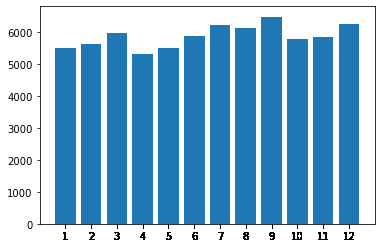

127.0.0.1 - - [19/Feb/2020 18:53:14] "GET /year HTTP/1.1" 200 -


In [33]:
app = Flask(__name__)

@app.route("/year", methods=['GET'])
def year():

    query = "SELECT year, month, births FROM births2 WHERE year = (SELECT year FROM births2 GROUP BY year ORDER BY sum(births) DESC LIMIT 1)"

    try:
        df = pd.read_sql(query, connection)
        
        ano = df["year"][0]
        
        plt.bar(df['month'], df['births'])
        plt.xticks(df['month'])
        plt.show()
      
        return 'Sucesso! Ano {} com maior número de pessoas.'.format(int(ano)), 200
    except:
        return "Não foi possível fazer SELECT na tabela.", 500

app.run(port=5001)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5001/ (Press CTRL+C to quit)


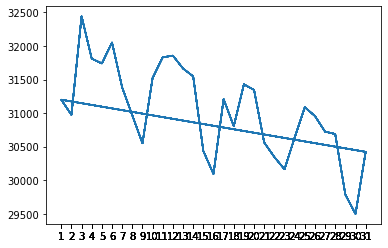

127.0.0.1 - - [19/Feb/2020 19:53:30] "GET /year HTTP/1.1" 200 -


In [101]:
app = Flask(__name__)

@app.route("/mes_F", methods=['GET'])
def mes_F():

    query = "SELECT day, month, births, gender FROM births2 WHERE gender = 'F'  AND day <= 31 AND month = (SELECT month FROM births2 GROUP BY month ORDER BY sum(births) DESC LIMIT 1)"

    try:
        df = pd.read_sql(query, connection)
        
        mes = df["month"][0]
        df['soma'] = df.groupby('day')["births"].transform(np.sum)
        
        plt.plot(df['day'], df['soma'])
        plt.xticks(df['day'])
        plt.show()
      
        return 'Sucesso! Mês {} com maior número de mulheres.'.format(int(mes)), 200
    except:
        return "Não foi possível fazer SELECT na tabela.", 500

app.run(port=5001)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5001/ (Press CTRL+C to quit)


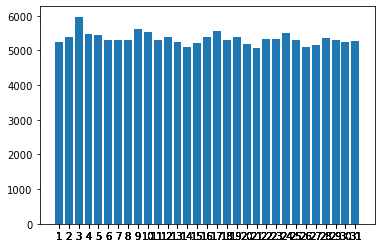

127.0.0.1 - - [19/Feb/2020 20:43:46] "GET /mes_M/3 HTTP/1.1" 200 -


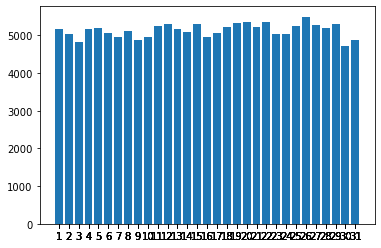

127.0.0.1 - - [19/Feb/2020 20:44:00] "GET /mes_M/5 HTTP/1.1" 200 -


In [123]:
app = Flask(__name__)

@app.route("/mes_M/<mes>", methods=['GET'])
def mes_M(mes):

    query = "SELECT month, births, day FROM births2 WHERE gender = 'M' AND day <= 31 AND month = {}".format(int(mes))

    try:
        df = pd.read_sql(query, connection)
              
        plt.bar(df['day'], df['births'])
        plt.xticks(df['day'])
        plt.show()
      
        return 'Sucesso! Mês {} com {} homens.'.format(int(mes), df['births'].sum()), 200
    except:
        return "Não foi possível fazer SELECT na tabela.", 500

app.run(port=5001)